In [475]:
from docutils.nodes import legend
from sympy import rotations
from sympy.abc import alpha
from sympy.printing.pretty.pretty_symbology import line_width

from ign_moveit2_examples.examples.py.analyse_data import color

#DataFile
fn = '/home/klaus/code/pymi2_ws/sim_data/out/testdata_v2_1k.dill'

#plot putput
figurefolder = '/home/klaus/code/pymi2_ws/sim_data/figures'

# reshuffle data this many times and relearn it (to plot average, deviation etc)
cfg_reshuffle_count = 9 

# stop learning after a certain amount of actions 
cfg_stop_learning_after_n_trials = 0

cfg_ignore_confusion_before_n_trials = cfg_stop_learning_after_n_trials
cfg_ignore_confusion_before_n_trials = 0
# check prediction accuracy only after n actions
cfg_ignore_accuracy_before_n_trials = cfg_stop_learning_after_n_trials
cfg_ignore_accuracy_before_n_trials = 100

cfg_n_bins = 10
cfg_bEqualBinSize = True # True have nearly equal amount of samples per bin, False: have equally wide bin intervals 
cfg_bMedianPrediction = False # Use median instead of mean for each bin's reported prediction

cfg_bSaveFigures = True


In [476]:
# in case of error:
# activate venv: "source venv/bin/activate"
# run "python -m ipykernel install --user --name=venv_pymi2
# select kernel in jupyter

In [477]:
import sys
import data_utils
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import math
import numpy as np
from math3d import (Transform, Orientation, PositionVector, Versor)
import classify
import random
from pathlib import Path
import analyse_data as ad

In [478]:
ad.fn = fn
ad.figurefolder = figurefolder


In [479]:
colours = {'blue':'#2c628cff',
           'yellow':'#ffb72dff',
           'red':'#c40900ff',
           'green':'#369424ff',
           'purple':'#8c00c0ff',
           'orange':'#ea6e00ff',
           'neutral':'#fbe5bcff',
           'background':'#fdf7edff',
           }

coloursdark = {'blue':'#00335cff',
           'yellow':'#996500ff',
           'red':'#610400ff',
           'green':'#1b4a12ff',
           'purple':'#470061ff',
           'orange':'#7a3a00ff',
           'neutral':'#e8ae6dff',
           'background':'#fdf7edff',
           }

colourslight= {'blue':'#65a1cdff',
           'yellow':'#fed17aff',
           'red':'#db685fff',
           'green':'#85bc75ff',
           'purple':'#b963d2ff',
           'orange':'#f1a55fff',
           'neutral':'#fcecd0ff',
           'background':'#fdf7edff',
           }

# TODO? implement easy way to lighten darken colors:
# https://stackoverflow.com/a/13542669
# https://github.com/PimpTrizkit/PJs/wiki/12.-Shade,-Blend-and-Convert-a-Web-Color-(pSBC.js)

In [480]:
# Uncomment for white-background figures
#mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = colours['background']

# Make graphs appear larger
plt.rcParams['figure.dpi'] = 200

# Change font
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

pd.set_option("display.precision", 2)

def figsave(plot_axis,prefix):
    if not cfg_bSaveFigures:
        return plot_axis
    p = Path(figurefolder)
    Path.mkdir(p, parents=True, exist_ok=True)
    i = 1
    fn = p / f'{prefix}_{i}.svg'
    fn_v = p / f'{prefix}_{i}.pdf'
    while fn.exists():
        i+=1
        fn = p / f'{prefix}_{i}.svg'
        fn_v = p / f'{prefix}_{i}.pdf'
        
    plot_axis.figure.savefig(fn)
    plot_axis.figure.savefig(fn_v,format='pdf')

    return plot_axis

In [481]:
# (clear) datalists
dl_seeds_int = [] # random seeds when reshuffled
dl_confusion_matrices_obj = [] # confusion matrix for prediction (including learning) 
dl_correct_prediction_ratios_over_n_pd = [] # 
dl_success_rates_vs_probability_predicted_pd = []

def clear_data():
    dl_seeds_int.clear()
    dl_confusion_matrices_obj.clear() 
    dl_correct_prediction_ratios_over_n_pd.clear() 
    dl_success_rates_vs_probability_predicted_pd.clear()

In [482]:
tf_lookup = {True: 1.0, False: 0.0}

def get_succ_prob(pred_prob_list):
    if len(pred_prob_list) <1 :
        return None
    if True in pred_prob_list:
        return pred_prob_list[True]
    else:
        return 1.0-pred_prob_list[False]

def relearn_and_get_data(simdata,bShuffle=False,bPrint=True,bProbabilityPred=True):
    
    clf = classify.Classifyer()
    clf.resetConfusion()
    
    predicted_probability__iter = []
    result__iter = []
    
    if bShuffle:
        r_seed = random.randrange(sys.maxsize)
        if bPrint:
            print(f'Randomized list with seed: {r_seed}')
        dl_seeds_int.append(r_seed)
        random.seed(r_seed)
        random.shuffle(simdata)
    else:
        dl_seeds_int.append(0)
        
    learned_count = 0
    

    for e in simdata:
        assert isinstance(e, data_utils.DataEntry)
        pred = clf.predict(e.sampled_variance)
        pred_prob = clf.predict_prob(e.sampled_variance)
        outcome = e.b_outcome
        if learned_count < cfg_stop_learning_after_n_trials or cfg_stop_learning_after_n_trials < 1:
            clf.learn(e.sampled_variance, outcome)        
        learned_count += 1
        clf.storeOutcome(pred, outcome)
        
        if learned_count == cfg_ignore_confusion_before_n_trials and cfg_ignore_confusion_before_n_trials > 0:
            clf.resetConfusion()

        tmp = get_succ_prob(pred_prob)
        if tmp is not None:
            predicted_probability__iter.append(tmp)
            result__iter.append(tf_lookup[e.b_outcome])
    
    pred_ratio_iterative = clf.get_equal_ratios().copy()
    
    dl_confusion_matrices_obj.append(ad.confusion_data_binary(clf.confusion,bPrint=bPrint))
    
    pd_correct_prediction_ratios = pd.DataFrame({ 'pred_cum_ratio_iter': pred_ratio_iterative})
    
    dl_correct_prediction_ratios_over_n_pd.append(pd_correct_prediction_ratios)        
    
    if not bProbabilityPred:
        dl_success_rates_vs_probability_predicted_pd.append(None)
        return
    
    pd_pred_probabilities_iter = pd.DataFrame(
        {
            'probability_predicted': predicted_probability__iter,
            'outcome': result__iter
        }
    )
        
    if cfg_ignore_accuracy_before_n_trials > 0:
        pd_binned_probabilities = pd_pred_probabilities_iter.copy()[cfg_ignore_accuracy_before_n_trials:]
    else:
        pd_binned_probabilities = pd_pred_probabilities_iter.copy()
    bin_labels = []
    for b in range(cfg_n_bins):
        bin_labels.append(str(b+1))

    if cfg_bEqualBinSize:
        # equal count in bin
        pd_binned_probabilities["interval"] = pd.qcut(pd_binned_probabilities['probability_predicted'],cfg_n_bins)
    else:
        # equal bin width
        pd_binned_probabilities["interval"]=pd.cut(pd_binned_probabilities['probability_predicted'],np.linspace(0,1, cfg_n_bins+1),right=True,include_lowest=True)
        
    pd_tmp = pd_binned_probabilities.groupby("interval",observed=True).mean()    
    if cfg_bMedianPrediction:
        pd_tmp["probability_predicted"] = pd_binned_probabilities.groupby("interval",observed=True).median()["probability_predicted"]
    pd_tmp["diff"] = pd_tmp["probability_predicted"] - pd_tmp["outcome"]
    pd_tmp['bins'] = bin_labels
    pd_tmp['n'] = pd_binned_probabilities.groupby("interval",observed=True).count()['outcome']
    pd_tmp['s'] = pd_binned_probabilities.groupby("interval",observed=True).sum()['outcome']
    pd_tmp['inter'] = pd_tmp.index

    pd_print = pd_tmp[['bins','inter','n','s','probability_predicted','outcome','diff']]
    if bPrint:
        print(pd_print.to_string(index=False))
        df = pd_print.style.format(decimal='.', thousands=',', precision=2)
        print(df.to_latex())
         
    dl_success_rates_vs_probability_predicted_pd.append(pd_tmp)
        

In [483]:
clear_data()
simdata = ad.load_file(fn)

relearn_and_get_data(simdata,bShuffle=False,bPrint=True,bProbabilityPred=True)

for i in range(cfg_reshuffle_count):
    relearn_and_get_data(simdata,bShuffle=True, bPrint=False,bProbabilityPred=True)

#data_original = ad.data_2_pandas(simdata)

272.0 366.0 196.0 165.0
------------------
      / Predicted
Act. /
        False   True  
False     366    196  
 True     165    272  
sum         : 999.0
succesfull interactions: 437.0
correct predictions: 638.0
accuracy    : 0.64
error       : 0.36
precision   : 0.58
recall      : 0.62
specificity : 0.65
------------------

bins              inter  n    s  probability_predicted  outcome      diff
   1 (-0.000554, 0.121] 90 23.0                   0.06     0.26 -1.99e-01
   2     (0.121, 0.228] 90 20.0                   0.18     0.22 -4.67e-02
   3     (0.228, 0.323] 90 26.0                   0.28     0.29 -1.38e-02
   4     (0.323, 0.416] 90 29.0                   0.37     0.32  4.38e-02
   5     (0.416, 0.486] 90 36.0                   0.45     0.40  5.25e-02
   6     (0.486, 0.548] 89 37.0                   0.52     0.42  1.03e-01
   7     (0.548, 0.607] 90 45.0                   0.58     0.50  7.82e-02
   8      (0.607, 0.67] 90 49.0                   0.64     0.54  9.53e-02
   9

<AxesSubplot: xlabel='Prediction Interval', ylabel='Probability / Rate'>

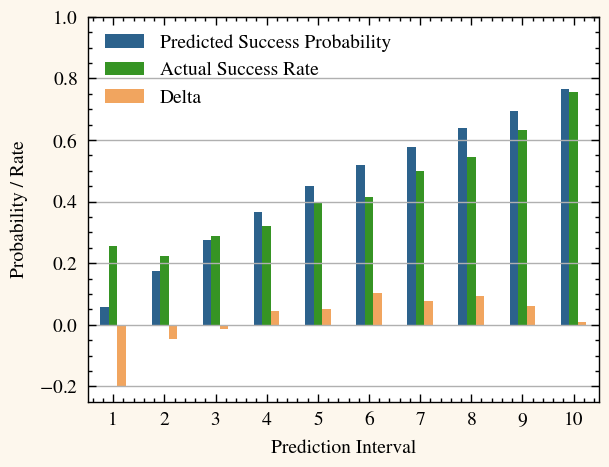

In [489]:
# learned probaility prediction

ax = plt.axes()
#ax.set_facecolor(colours['background'])
dl_success_rates_vs_probability_predicted_pd[0].plot(x='bins', y=['probability_predicted', 'outcome', 'diff'], kind='bar', grid=False, color=[colours['blue'],colours['green'],colourslight['orange']],ax=ax)

ax.set_ylim([-0.25, 1])
ax.legend(["Predicted Success Probability","Actual Success Rate","Delta"])
plt.grid(axis='y',zorder=0)
plt.xlabel('Prediction Interval')
plt.ylabel('Probability / Rate')
plt.xticks(rotation=0)



figsave(ax,'fig_pred_probability')


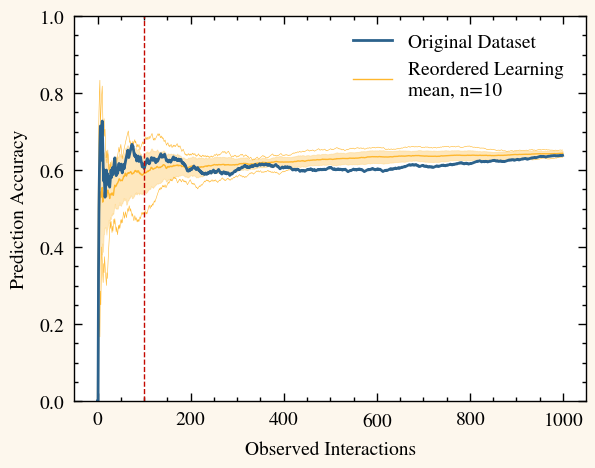

<AxesSubplot: xlabel='Observed Interactions', ylabel='Prediction Accuracy'>

In [485]:
# Learned Binary prediction Accuracy

c1 = 'blue'
c2 = 'yellow'
c3 = 'red'


bHasStatistic = cfg_reshuffle_count > 0


ax = plt.axes()
label_main = 'Original Dataset'

if bHasStatistic:
    # https://stackoverflow.com/questions/70454007/plotting-multiple-data-sets-as-one-average-and-adding-error-bars-matplotlib
    pd_all = pd.DataFrame()
    
    for i in range(cfg_reshuffle_count+1):
        pd_all[f'run_{i}']=dl_correct_prediction_ratios_over_n_pd[i][['pred_cum_ratio_iter']]
        
    pd_all_info = pd_all.T.describe().T                
    
    plt.fill_between(pd_all_info.index, y1=pd_all_info['mean']-pd_all_info['std'],y2=pd_all_info['mean']+pd_all_info['std'],color=colourslight[c2],alpha=0.5,linewidth=0.3)
    #plt.plot()
    #plt.plot(pd_all_info['mean']-pd_all_info['std'])
    plt.plot(pd_all_info['mean'],color=colours[c2],linewidth=0.5,label="l1")
    plt.plot(pd_all_info['min'],color=colours[c2],linewidth=0.2)
    plt.plot(pd_all_info['max'],color=colours[c2],linewidth=0.2)


    
plt.plot(dl_correct_prediction_ratios_over_n_pd[0][['pred_cum_ratio_iter']],color=colours[c1],label=label_main)

#dl_correct_prediction_ratios_over_n_pd[0][['pred_cum_ratio_iter']].plot()
if bHasStatistic:
    l_handles, l_lables = plt.gca().get_legend_handles_labels()
    ax.legend([l_handles[1],l_handles[0]],[label_main,f'Reordered Learning \nmean, n={cfg_reshuffle_count+1}'])
else:
    ax.legend([label_main])

if cfg_ignore_accuracy_before_n_trials > 0:
    plt.plot([cfg_ignore_accuracy_before_n_trials,cfg_ignore_accuracy_before_n_trials],[0,1], label="line",linestyle='dashed',color=colours[c3],linewidth=0.5)

ax.set_ylim([0, 1])

plt.xlabel('Observed Interactions')
plt.ylabel('Prediction Accuracy')

plt.show()
    
figsave(ax,'fig_pred_accuracy')

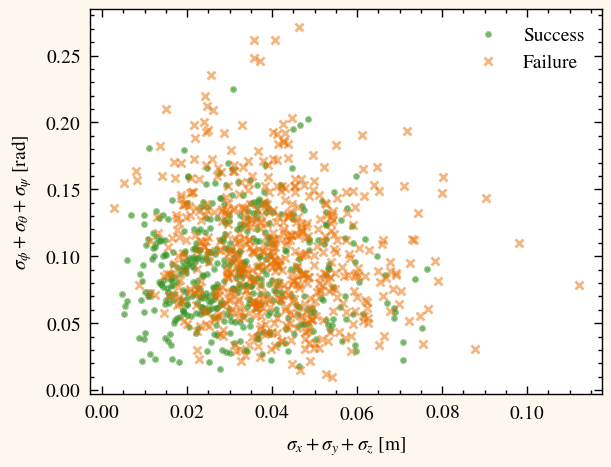

<AxesSubplot: xlabel='$\\sigma_x+\\sigma_y+\\sigma_z$ [m]', ylabel='$\\sigma_\\phi+\\sigma_\\theta+\\sigma_\\psi$ [rad]'>

In [486]:
#Data Scatter

pd_data = ad.data_2_pandas(simdata)

c_fail = 'orange'
c_succ = 'green'

xn = 'sum_s_trans'
yn = 'sum_s_rot'

ax = None

ax = pd_data.loc[pd_data['success'] == 1].plot(x=xn, y=yn, ax =ax, marker='.', c=colours[c_succ], linestyle='', alpha =0.5)
ax = pd_data.loc[pd_data['success'] == 0].plot(x=xn, y=yn, ax=ax, marker='x', c=colours[c_fail], linestyle='', alpha =0.5)
#ax.set_facecolor(colours['background'])

#ax = pd_data.loc[pd_data['success'] == 0].plot(x=xn, y=yn, ax=ax, marker='x', c=colours[c_fail], linestyle='')
ax.legend(['Success','Failure'])

plt.xlabel(r'$\sigma_x+\sigma_y+\sigma_z$ [m]')
plt.ylabel(r'$\sigma_\phi+\sigma_\theta+\sigma_\psi$ [rad]')


plt.show()

figsave(ax,'fig_success_scatter_sigma')
